In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

In [2]:
def loadseq(file):
    lines = []
    with open(file, 'r') as file:
        for line in file:
            lines.append(line.strip())
    return lines


glutfile = 'glutoutputnoheader.fasta'
sgltfile = 'newsgltoutputnoheader.fasta'
sweetfile = 'newsweetoutputnoheader.fasta'
# hxtfile = 'hxtoutputnoheader.fasta'
# chbfile = 'chboutputnoheader.fasta'


glut = loadseq(glutfile)
sglt = loadseq(sgltfile)
sweet = loadseq(sweetfile)
# hxt = loadseq(hxtfile)
# chb = loadseq(chbfile)

# glut = glut[:25]
# hxt = hxt[:25]
# chb = chb[:5]

glutlen = len(glut)
sgltlen = len(sglt)
sweetlen = len(sweet)
# hxtlen = len(hxt)
# chblen = len(chb)

len(glut),len(sglt),len(sweet)

(396, 24, 675)

In [3]:
amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # List of amino acids
n_amino_acids = len(amino_acids)  # Number of amino acids

In [4]:
def calculate_aac_features(sequences, amino_acids):
    n_amino_acids = len(amino_acids)
    features = []
    for fasta_sequence in sequences:
        aac = np.zeros(n_amino_acids)
        for aa in fasta_sequence:
            if aa in amino_acids:
                index = amino_acids.index(aa)
                aac[index] += 1

        # Normalize the amino acid composition to obtain relative frequencies
        aac /= len(fasta_sequence)

        # Append the AAC feature vector to the feature list
        features.append(aac)

    return np.array(features)

In [5]:
glut_ = calculate_aac_features(glut,amino_acids)
sglt_ = calculate_aac_features(sglt,amino_acids)
sweet_ = calculate_aac_features(sweet,amino_acids)
# hxt_ = calculate_aac_features(hxt,amino_acids)
# chb_ = calculate_aac_features(chb,amino_acids)

In [6]:
glut_test_count = 47
sglt_test_count = 6
sweet_test_count = 47

x_train = np.concatenate((glut_[:glutlen-glut_test_count], sglt_[:sgltlen-sglt_test_count], sweet_[:sweetlen-sweet_test_count]), axis=0)
x_test = np.concatenate((glut_[glutlen-glut_test_count:], sglt_[sgltlen-sglt_test_count:], sweet_[sweetlen-sweet_test_count:]), axis=0)

# x_train = np.concatenate((glut_[:glutlen-1], sglt_[:sgltlen-1], hxt_[:hxtlen-1], chb_[:chblen-1]), axis=0)
# x_test = np.concatenate((glut_[glutlen-1:], sglt_[sgltlen-1:], hxt_[hxtlen-1:], chb_[chblen-1:]), axis=0)

# Create the corresponding labels

y_train = np.array(["GLUT"] * (glutlen-glut_test_count) + ["SGLT"] * (sgltlen-sglt_test_count) + ["SWEET"] * (sweetlen-sweet_test_count))
y_test = np.array(["GLUT"] * glut_test_count + ["SGLT"] * sglt_test_count + ["SWEET"] * sweet_test_count)

# y_train = np.array(["GLUT"] * (glutlen-1) + ["SGLT"] * (sgltlen-1) + ["HXT"] * (hxtlen-1) + ["CHB"] * (chblen-1))
# y_test = np.array(["GLUT"] * 1 + ["SGLT"] * 1 + ["HXT"] * 1 + ["CHB"] * 1)

x_train.shape

(995, 20)

Training Accuracy (RandomForestClassifier): 0.9979899497487437
Test Accuracy (RandomForestClassifier): 0.79
Training Accuracy (SVC): 0.9065326633165829
Test Accuracy (SVC): 0.82
Training Accuracy (KNeighborsClassifier): 0.9125628140703518
Test Accuracy (KNeighborsClassifier): 0.84
Training Accuracy (XGBoost): 0.9979899497487437
Test Accuracy (XGBoost): 0.86


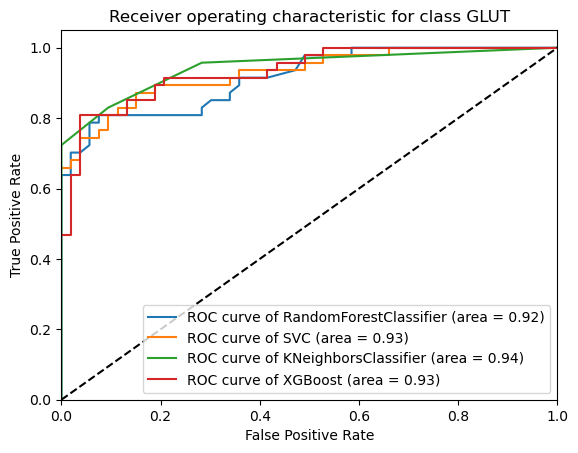

Training Accuracy (RandomForestClassifier): 0.9979899497487437
Test Accuracy (RandomForestClassifier): 0.8
Training Accuracy (SVC): 0.9095477386934674
Test Accuracy (SVC): 0.82
Training Accuracy (KNeighborsClassifier): 0.9125628140703518
Test Accuracy (KNeighborsClassifier): 0.84
Training Accuracy (XGBoost): 0.9979899497487437
Test Accuracy (XGBoost): 0.86


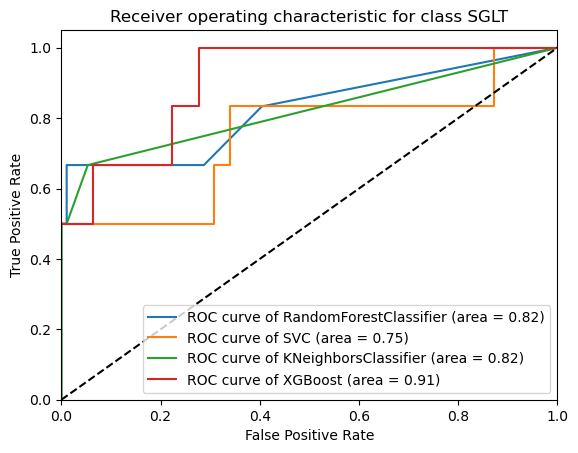

Training Accuracy (RandomForestClassifier): 0.9979899497487437
Test Accuracy (RandomForestClassifier): 0.79
Training Accuracy (SVC): 0.907537688442211
Test Accuracy (SVC): 0.82
Training Accuracy (KNeighborsClassifier): 0.9125628140703518
Test Accuracy (KNeighborsClassifier): 0.84
Training Accuracy (XGBoost): 0.9979899497487437
Test Accuracy (XGBoost): 0.86


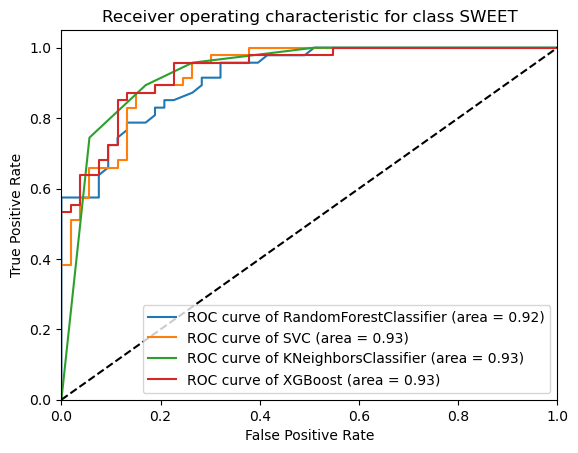

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

# Assume x_train, y_train, x_test, y_test are pre-defined

# Initialize classifiers
classifiers = [
    RandomForestClassifier(),
    svm.SVC(probability=True),
    KNeighborsClassifier(n_neighbors=4),
    xgb.XGBClassifier(eval_metric='mlogloss')  # disable the label encoder warning
]

# Preprocessing
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.fit_transform(y_test)
y_test_bin = label_binarize(y_test_enc, classes=list(set(y_test_enc)))
n_classes = y_test_bin.shape[1]

# Define classifiers names
names = ['RandomForestClassifier', 'SVC', 'KNeighborsClassifier', 'XGBoost']
label = ["GLUT","SGLT","SWEET"]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
accuracy = dict()

for i in range(n_classes):
    plt.figure()
    for classifier, name in zip(classifiers, names):
        classifier.fit(x_train, y_train_enc)
        y_score_train = classifier.predict_proba(x_train)
        y_score_test = classifier.predict_proba(x_test)

        y_pred_train = np.argmax(y_score_train, axis=1)
        train_accuracy = accuracy_score(y_train_enc, y_pred_train)
        print("Training Accuracy ({0}): {1}".format(name,train_accuracy))

        y_pred_test = np.argmax(y_score_test, axis=1)
        test_accuracy = accuracy_score(y_test_enc, y_pred_test)
        print("Test Accuracy ({0}): {1}".format(name,test_accuracy))

        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_test[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i],
                 label='ROC curve of {0} (area = {1:0.2f})'.format(name, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class {0}'.format(label[i]))
    plt.legend(loc="lower right")
    plt.show()


Training Accuracy (RandomForestClassifier): 0.9979899497487437
Test Accuracy (RandomForestClassifier): 0.81
Confusion matrix for RandomForestClassifier:
Training Accuracy (SVC): 0.9065326633165829
Test Accuracy (SVC): 0.82
Confusion matrix for SVC:
Training Accuracy (KNeighborsClassifier): 0.9125628140703518
Test Accuracy (KNeighborsClassifier): 0.84
Confusion matrix for KNeighborsClassifier:
Training Accuracy (XGBoost): 0.9979899497487437
Test Accuracy (XGBoost): 0.86
Confusion matrix for XGBoost:


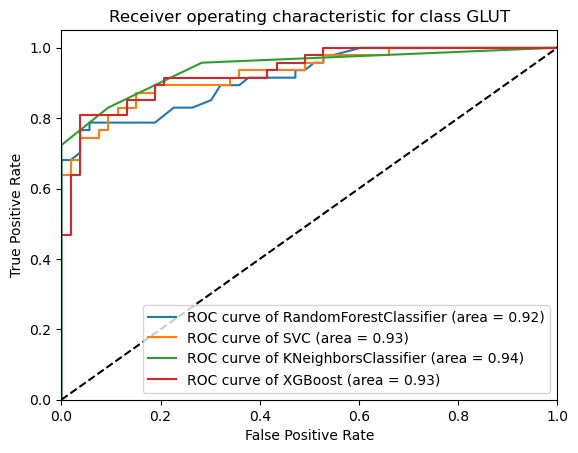

Training Accuracy (RandomForestClassifier): 0.9979899497487437
Test Accuracy (RandomForestClassifier): 0.79
Confusion matrix for RandomForestClassifier:
Training Accuracy (SVC): 0.9065326633165829
Test Accuracy (SVC): 0.82
Confusion matrix for SVC:
Training Accuracy (KNeighborsClassifier): 0.9125628140703518
Test Accuracy (KNeighborsClassifier): 0.84
Confusion matrix for KNeighborsClassifier:
Training Accuracy (XGBoost): 0.9979899497487437
Test Accuracy (XGBoost): 0.86
Confusion matrix for XGBoost:


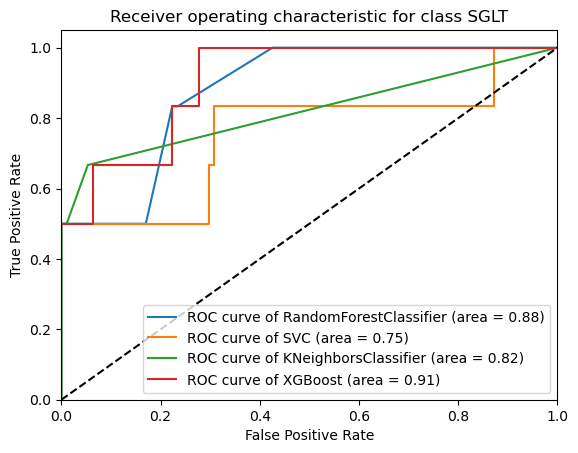

Training Accuracy (RandomForestClassifier): 0.9979899497487437
Test Accuracy (RandomForestClassifier): 0.79
Confusion matrix for RandomForestClassifier:
Training Accuracy (SVC): 0.907537688442211
Test Accuracy (SVC): 0.82
Confusion matrix for SVC:
Training Accuracy (KNeighborsClassifier): 0.9125628140703518
Test Accuracy (KNeighborsClassifier): 0.84
Confusion matrix for KNeighborsClassifier:
Training Accuracy (XGBoost): 0.9979899497487437
Test Accuracy (XGBoost): 0.86
Confusion matrix for XGBoost:


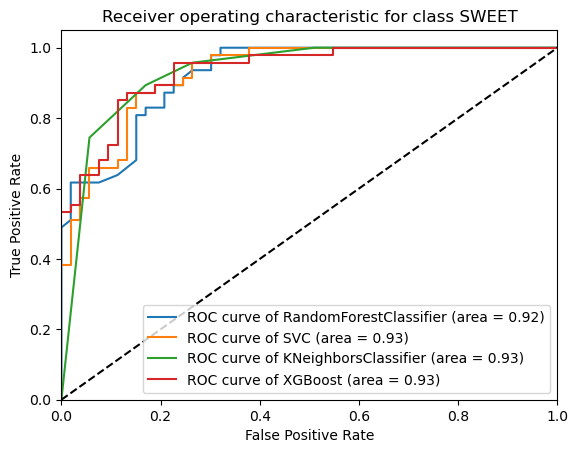

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

# Assume x_train, y_train, x_test, y_test are pre-defined

# Initialize classifiers
classifiers = [
    RandomForestClassifier(),
    svm.SVC(probability=True),
    KNeighborsClassifier(n_neighbors=4),
    xgb.XGBClassifier(eval_metric='mlogloss')  # disable the label encoder warning
]

# Preprocessing
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.fit_transform(y_test)
y_test_bin = label_binarize(y_test_enc, classes=list(set(y_test_enc)))
n_classes = y_test_bin.shape[1]

# Define classifiers names
names = ['RandomForestClassifier', 'SVC', 'KNeighborsClassifier', 'XGBoost']
label = ["GLUT","SGLT","SWEET"]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
accuracy = dict()

confusion_metrics = dict() # Dictionary to store confusion matrix results

for i in range(n_classes):
    plt.figure()
    for classifier, name in zip(classifiers, names):
        classifier.fit(x_train, y_train_enc)
        y_score_train = classifier.predict_proba(x_train)
        y_score_test = classifier.predict_proba(x_test)

        y_pred_train = np.argmax(y_score_train, axis=1)
        train_accuracy = accuracy_score(y_train_enc, y_pred_train)
        print("Training Accuracy ({0}): {1}".format(name,train_accuracy))

        y_pred_test = np.argmax(y_score_test, axis=1)
        test_accuracy = accuracy_score(y_test_enc, y_pred_test)
        print("Test Accuracy ({0}): {1}".format(name,test_accuracy))

        # Compute confusion matrix 
        cm = confusion_matrix(y_test_enc, y_pred_test)
        print("Confusion matrix for {0}:".format(name))
        confusion_metrics[name] = cm  # Save results to dictionary

        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score_test[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i],
                 label='ROC curve of {0} (area = {1:0.2f})'.format(name, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class {0}'.format(label[i]))
    plt.legend(loc="lower right")
    plt.show()




In [9]:
def get_class_metrics(cm, class_i):
    tp = cm[class_i, class_i]
    fn = np.sum(cm[class_i, :]) - tp
    fp = np.sum(cm[:, class_i]) - tp
    tn = np.sum(cm) - tp - fn - fp
    return tp, tn, fp, fn


In [10]:
tp, tn, fp, fn = get_class_metrics(confusion_metrics['RandomForestClassifier'], 0)
print(confusion_metrics)

{'RandomForestClassifier': array([[33,  0, 14],
       [ 3,  1,  2],
       [ 2,  0, 45]], dtype=int64), 'SVC': array([[33,  0, 14],
       [ 1,  3,  2],
       [ 1,  0, 46]], dtype=int64), 'KNeighborsClassifier': array([[39,  0,  8],
       [ 1,  3,  2],
       [ 4,  1, 42]], dtype=int64), 'XGBoost': array([[38,  0,  9],
       [ 0,  3,  3],
       [ 2,  0, 45]], dtype=int64)}


In [11]:
def calEval(tp,tn,fp,fn):
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    OAcc = (tp+tn)/(tp+fp+tn+fn)
    BalAcc = (sens+spec)/2
    MCC = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    
    return sens*100,spec*100,OAcc*100,BalAcc*100,MCC

In [12]:
def drawTable(confusion_metrics, names, label):
    rows = []
    for i in range(len(names)):
        for j in range(len(label)):
            tp, tn, fp, fn = get_class_metrics(confusion_metrics[names[i]], j)
            sens, spec, OAcc, BalAcc, MCC = calEval(tp, tn, fp, fn)
            rows.append([f"{names[i]} ({label[j]})", sens, spec, OAcc, BalAcc, MCC])
    headers = ["Classifier Name (Class)", "Sens(%)", "Spec(%)", "Overall Acc(%)", "Bal Acc(%)", "MCC"]
    print(tabulate(rows, headers, tablefmt='pipe'))

drawTable(confusion_metrics, names, label)


| Classifier Name (Class)        |   Sens(%) |   Spec(%) |   Overall Acc(%) |   Bal Acc(%) |      MCC |
|:-------------------------------|----------:|----------:|-----------------:|-------------:|---------:|
| RandomForestClassifier (GLUT)  |   70.2128 |   90.566  |               81 |      80.3894 | 0.624959 |
| RandomForestClassifier (SGLT)  |   16.6667 |  100      |               95 |      58.3333 | 0.397805 |
| RandomForestClassifier (SWEET) |   95.7447 |   69.8113 |               82 |      82.778  | 0.670814 |
| SVC (GLUT)                     |   70.2128 |   96.2264 |               84 |      83.2196 | 0.695217 |
| SVC (SGLT)                     |   50      |  100      |               97 |      75      | 0.696086 |
| SVC (SWEET)                    |   97.8723 |   69.8113 |               83 |      83.8418 | 0.695958 |
| KNeighborsClassifier (GLUT)    |   82.9787 |   90.566  |               87 |      86.7724 | 0.739466 |
| KNeighborsClassifier (SGLT)    |   50      |   98.9362 |      

In [13]:
from sklearn import svm

clf = svm.SVC()
clf.fit(x_train, y_train)

y_pred_train = clf.predict(x_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

y_pred_test = clf.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing Accuracy:", test_accuracy)

y_test, y_pred_test

Training Accuracy: 0.8904522613065327
Testing Accuracy: 0.77


(array(['GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'SGLT',
        'SGLT', 'SGLT', 'SGLT', 'SGLT', 'SGLT', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET'], dtype='<U5'),
 array(['SWEET', 'SWEET', 

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_train, y_train)

y_pred_train = knn.predict(x_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

y_pred_test = knn.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing Accuracy:", test_accuracy)

y_test, y_pred_test

Training Accuracy: 0.9125628140703518
Testing Accuracy: 0.84


(array(['GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'SGLT',
        'SGLT', 'SGLT', 'SGLT', 'SGLT', 'SGLT', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET'], dtype='<U5'),
 array(['GLUT', 'GLUT', 'G

In [15]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y_train))
model.fit(x_train, y_train)

y_pred_train_prob = model.predict_proba(x_train)
y_pred_train = np.argmax(y_pred_train_prob, axis=1)
print(len(y_train))
print(len(y_pred_train))
train_accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", train_accuracy)

y_pred_test_prob = model.predict_proba(x_test)
y_pred_test = np.argmax(y_pred_test_prob, axis=1)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Testing Accuracy:", test_accuracy)

y_test = encoder.inverse_transform(y_test)
y_pred_test = encoder.inverse_transform(y_pred_test)
y_test,y_pred_test

995
995
Training Accuracy: 0.9979899497487437
Testing Accuracy: 0.86


(array(['GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT',
        'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'GLUT', 'SGLT',
        'SGLT', 'SGLT', 'SGLT', 'SGLT', 'SGLT', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET', 'SWEET',
        'SWEET', 'SWEET'], dtype='<U5'),
 array(['SWEET', 'GLUT', '